In [1]:
import os
import sys
import pickle

import pandas as pd
import numpy as np

import torch
import torch.nn as nn

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb

import optuna

import transformers

from tqdm import tqdm
import matplotlib.pyplot as plt

sys.path.append('/home/backe/projects/feedback/')
from utils import score_feedback_comp, calc_overlap
# from utils_candidates import score_feedback_comp, calc_overlap
from decoder_2000.candidates import *

# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
# VAL_DF
TRAIN_PATH = '../data/train.csv'
train_df = pd.read_csv(TRAIN_PATH)

folds_df = pd.read_csv('../data/folds.csv')

In [3]:
with open('word_probs_lf.pickle', 'rb') as handle:
    word_probs_lf = pickle.load(handle)
    
with open('word_probs_rl.pickle', 'rb') as handle:
    word_probs_rl = pickle.load(handle)

with open('word_probs_db.pickle', 'rb') as handle:
    word_probs_db = pickle.load(handle)

In [4]:
word_probs_all = {}

for idx in word_probs_lf.keys():
    
    word_probs_all[idx] = np.mean((word_probs_lf[idx], word_probs_rl[idx], word_probs_db[idx]), axis=0)


### Make dataset

In [5]:
def get_target(preds_df, gt_df, discourse_type):
    """
    A function that scores for the kaggle
        Student Writing Competition
        
    Uses the steps in the evaluation page here:
        https://www.kaggle.com/c/feedback-prize-2021/overview/evaluation
    """
    
    pred_df = preds_df.copy()
    
    gt_df = gt_df.loc[gt_df['discourse_type'] == discourse_type, 
                      ['id', 'predictionstring']].reset_index(drop=True)
    pred_df = pred_df.loc[pred_df['class'] == discourse_type,
                      ['id', 'predictionstring']].reset_index(drop=True)
    pred_df['pred_id'] = pred_df.index
    gt_df['gt_id'] = gt_df.index
    pred_df['predictionstring'] = [set(pred.split(' ')) for pred in pred_df['predictionstring']]
    gt_df['predictionstring'] = [set(pred.split(' ')) for pred in gt_df['predictionstring']]
    
    # Step 1. all ground truths and predictions for a given class are compared.
    joined = pred_df.merge(gt_df,
                           left_on='id',
                           right_on='id',
                           how='outer',
                           suffixes=('_pred','_gt')
                          )
    joined['overlaps'] = [calc_overlap(*args) for args in zip(joined.predictionstring_pred, 
                                                     joined.predictionstring_gt)]
    
    preds_df['target'] = pred_df['pred_id'].apply(lambda pid: joined.loc[joined['pred_id'] == pid, 'overlaps'].any())
    
    return preds_df

In [6]:
lead_filt = (train_df['discourse_type'] == 'Lead')
lead_df = train_df[lead_filt]
lead_df.head()

position_filt = (train_df['discourse_type'] == 'Position')
position_df = train_df[position_filt]
position_df.head()

conc_filt = (train_df['discourse_type'] == 'Concluding Statement')
conclude_df = train_df[conc_filt]
conclude_df.head()

claim_filt = (train_df['discourse_type'] == 'Claim')
claim_df = train_df[claim_filt]
claim_df.head()

evidence_filt = (train_df['discourse_type'] == 'Evidence')
evidence_df = train_df[evidence_filt]
evidence_df.head()

count_filt = (train_df['discourse_type'] == 'Counterclaim')
count_df = train_df[count_filt]
count_df.head()

reb_filt = (train_df['discourse_type'] == 'Rebuttal')
reb_df = train_df[reb_filt]
reb_df.head()

,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring
19,6B4F7A0165B9,1.622644e+12,1440.0,1681.0,The problem becomes apparent that this is a se...,Rebuttal,Rebuttal 1,254 255 256 257 258 259 260 261 262 263 264 26...
119,019328A0D7A3,1.622467e+12,1436.0,1498.0,"In reality, everyone from every age is irrespo...",Rebuttal,Rebuttal 1,248 249 250 251 252 253 254 255 256
242,CC296299ABA4,1.622766e+12,2084.0,2141.0,"While that is true, it is highly unlikely and ...",Rebuttal,Rebuttal 1,360 361 362 363 364 365 366 367 368 369
300,7FF6281EC288,1.622554e+12,562.0,605.0,you could lose your good drivers discount.,Rebuttal,Rebuttal 1,93 94 95 96 97 98 99
322,89808E74DDC5,1.622825e+12,2630.0,2755.0,"However, talking or texting on cell phones whi...",Rebuttal,Rebuttal 1,458 459 460 461 462 463 464 465 466 467 468 46...


### Optuna Search

In [7]:
# get lead candidates

class_preds = []

for idx in word_probs_all.keys():
    
    word_probs = word_probs_all[idx]

    class_preds += cand_lead_position(idx, word_probs, lead_info['p_start'], lead_info['p_end'], 7)

lead_cand_df = pd.DataFrame(class_preds, columns=['id', 'class', 'predictionstring', 'prob_values', 'before_class', 'after_class'])

# score = score_feedback_comp(lead_cand_df, lead_df)
# print(score)

lead_cand_df = get_target(lead_cand_df, lead_df, 'Lead')

In [8]:
# get position candidates

class_preds = []

for idx in word_probs_all.keys():
    
    word_probs = word_probs_all[idx]

    class_preds += cand_lead_position(idx, word_probs, pos_info['p_start'], pos_info['p_end'], 5)

pos_cand_df = pd.DataFrame(class_preds, columns=['id', 'class', 'predictionstring', 'prob_values', 'before_class', 'after_class'])

# score = score_feedback_comp(pos_cand_df, position_df)
# print(score)

pos_cand_df = get_target(pos_cand_df, position_df, 'Position')

In [9]:
# get concluding statement candidates

class_preds = []

for idx in word_probs_all.keys():
    
    word_probs = word_probs_all[idx]

    class_preds += cand_conc_stat(idx, word_probs, conc_info['min_word_prob'], 6)

conc_cand_df = pd.DataFrame(class_preds, columns=['id', 'class', 'predictionstring', 'prob_values', 'before_class', 'after_class'])

# score = score_feedback_comp(conc_cand_df, conclude_df)
# print(score)

conc_cand_df = get_target(conc_cand_df, conclude_df, 'Concluding Statement')

In [10]:
# get claim candidates

class_preds = []

for idx in word_probs_all.keys():
    
    word_probs = word_probs_all[idx]
    
    class_preds += cand_claim_evidence(idx, word_probs, 2, 1)

claim_cand_df = pd.DataFrame(class_preds, columns=['id', 'class', 'predictionstring', 'prob_values', 'before_class', 'after_class'])

# score = score_feedback_comp(claim_cand_df, claim_df)
# print(score)

claim_cand_df = get_target(claim_cand_df, claim_df, 'Claim')

In [11]:
# get evidence candidates

class_preds = []

for idx in word_probs_all.keys():
    
    word_probs = word_probs_all[idx]
    
    class_preds += cand_claim_evidence(idx, word_probs, 4, 3)

evidence_cand_df = pd.DataFrame(class_preds, columns=['id', 'class', 'predictionstring', 'prob_values', 'before_class', 'after_class'])

# score = score_feedback_comp(evidence_cand_df, evidence_df)
# print(score)

evidence_cand_df = get_target(evidence_cand_df, evidence_df, 'Evidence')

In [ ]:
# # get counterclaim candidates

# class_preds = []

# for idx in word_probs_all.keys():
    
#     word_probs = word_probs_all[idx]

#     class_preds += cand_count_reb(idx, word_probs, 8, count_info['prob'])

# count_cand_df = pd.DataFrame(class_preds, columns=['id', 'class', 'predictionstring', 'prob_values', 'before_class', 'after_class'])

# score = score_feedback_comp(count_cand_df.copy(), count_df.copy())
# print(score)
# count_cand_df = get_target(count_cand_df, count_df, 'Counterclaim')

In [ ]:
# # get rebuttal candidates

# class_preds = []

# for idx in word_probs_all.keys():
    
#     word_probs = word_probs_all[idx]

#     class_preds += cand_count_reb(idx, word_probs, 9, rebuttal_info['prob'])

# reb_cand_df = pd.DataFrame(class_preds, columns=['id', 'class', 'predictionstring', 'prob_values', 'before_class', 'after_class'])

# score = score_feedback_comp(reb_cand_df, reb_df)
# print(score)

# reb_cand_df = get_target(reb_cand_df, reb_df, 'Rebuttal')

In [28]:
# get counterclaim candidates

class_preds = []

for idx in word_probs_all.keys():
    
    word_probs = word_probs_all[idx]

    class_preds += cand_count_reb(idx, word_probs, 8, 0.35)

count_cand_df = pd.DataFrame(class_preds, columns=['id', 'class', 'predictionstring', 'prob_values', 'before_class', 'after_class'])

score = score_feedback_comp(count_cand_df.copy(), count_df.copy())
print(score)
count_cand_df = get_target(count_cand_df, count_df, 'Counterclaim')

0.48802204791180837


In [29]:
# get rebuttal candidates

class_preds = []

for idx in word_probs_all.keys():
    
    word_probs = word_probs_all[idx]

    class_preds += cand_count_reb(idx, word_probs, 9, 0.35)

reb_cand_df = pd.DataFrame(class_preds, columns=['id', 'class', 'predictionstring', 'prob_values', 'before_class', 'after_class'])

score = score_feedback_comp(reb_cand_df, reb_df)
print(score)

reb_cand_df = get_target(reb_cand_df, reb_df, 'Rebuttal')

0.3950815290029404


In [49]:
def objective(trial):
    
    n_estimators = 4
    num_leaves = trial.suggest_int('num_leaves', 60, 160, 20)
    max_depth = trial.suggest_int('max_depth', 10, 20, 1)
    min_child_samples = trial.suggest_int('min_child_samples', 200, 600, 50)
    
    prob_count = trial.suggest_float('prob_count', 0.3, 0.4, step=0.01)
    prob_rebuttal = trial.suggest_float('prob_rebuttal', 0.3, 0.4, step=0.01)
    
    # get counterclaim candidates
    class_preds = []
    for idx in word_probs_all.keys():
        word_probs = word_probs_all[idx]
        class_preds += cand_count_reb(idx, word_probs, 8, prob_count)
    count_cand_df = pd.DataFrame(class_preds, columns=['id', 'class', 'predictionstring', 'prob_values', 'before_class', 'after_class'])
    count_cand_df = get_target(count_cand_df, count_df, 'Counterclaim')
    
    
    # get rebuttal candidates
    class_preds = []
    for idx in word_probs_all.keys():
        word_probs = word_probs_all[idx]
        class_preds += cand_count_reb(idx, word_probs, 9, prob_rebuttal)
    reb_cand_df = pd.DataFrame(class_preds, columns=['id', 'class', 'predictionstring', 'prob_values', 'before_class', 'after_class'])
    reb_cand_df = get_target(reb_cand_df, reb_df, 'Rebuttal')
    
    # CANDIDATES
    candidates_df = pd.concat((lead_cand_df, pos_cand_df, conc_cand_df, count_cand_df, reb_cand_df, claim_cand_df, evidence_cand_df)).copy()
    candidates_df = candidates_df.merge(folds_df, on='id') 
    
    # CREATE FEATURES
    candidates_df['class_enc'] = candidates_df['class'].map(discourse_encoder)
    candidates_df['mean'] = candidates_df['prob_values'].apply(lambda arr: arr.mean())
    candidates_df['num_words'] = candidates_df['prob_values'].apply(lambda arr: arr.size)
    candidates_df['max'] = candidates_df['prob_values'].apply(lambda arr: arr.max())
    candidates_df['min'] = candidates_df['prob_values'].apply(lambda arr: arr.min())
    candidates_df['max_delta'] = candidates_df['prob_values'].apply(lambda arr: get_max_delta(arr))
    candidates_df['high_mean'] = candidates_df['prob_values'].apply(lambda arr: high_mean(arr))
    
    clf = lgb.LGBMClassifier(n_estimators=n_estimators,
                             num_leaves=num_leaves,
                             max_depth=max_depth,
                             min_child_samples=min_child_samples)
    
    scores = []

    for fold_idx in range(5):

        fold_filt = (candidates_df['kfold'] == fold_idx)

        X_train = candidates_df.loc[~fold_filt, features]
        y_train = candidates_df.loc[~fold_filt, 'target']

        X_val = candidates_df.loc[fold_filt, features]
        y_val = candidates_df.loc[fold_filt, 'target']

        clf.fit(X_train, y_train)

        y_preds = clf.predict_proba(X_val)
        fold_preds = candidates_df[fold_filt].copy()
        fold_preds['preds'] = (y_preds[:, 1] >= 0.5)

        fold_ids = folds_df.loc[folds_df['kfold'] == fold_idx, 'id']
        fold_gt = train_df[train_df['id'].isin(fold_ids)]

        score_info = score_feedback_comp(fold_preds[fold_preds['preds'] == True], fold_gt, False)

        scores.append(score_info)

    scores = np.array(scores)
    
    return scores.mean()


In [50]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, timeout=60000000)

[I 2022-03-10 20:34:18,491] A new study created in memory with name: no-name-a87b41d2-f325-49ea-af4d-bccd9f87a43f
[I 2022-03-10 20:34:43,359] Trial 0 finished with value: 0.7076435643353658 and parameters: {'num_leaves': 80, 'max_depth': 19, 'min_child_samples': 200, 'prob_count': 0.39, 'prob_rebuttal': 0.37}. Best is trial 0 with value: 0.7076435643353658.
[I 2022-03-10 20:35:11,060] Trial 1 finished with value: 0.7071717460426206 and parameters: {'num_leaves': 60, 'max_depth': 11, 'min_child_samples': 600, 'prob_count': 0.31, 'prob_rebuttal': 0.37}. Best is trial 0 with value: 0.7076435643353658.
[I 2022-03-10 20:35:37,978] Trial 2 finished with value: 0.7069826443394842 and parameters: {'num_leaves': 80, 'max_depth': 19, 'min_child_samples': 450, 'prob_count': 0.37, 'prob_rebuttal': 0.39}. Best is trial 0 with value: 0.7076435643353658.
[I 2022-03-10 20:36:05,138] Trial 3 finished with value: 0.7071900808488087 and parameters: {'num_leaves': 100, 'max_depth': 11, 'min_child_samples'

In [26]:
pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]
print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Study statistics: 
  Number of finished trials:  50
  Number of pruned trials:  0
  Number of complete trials:  50
Best trial:
  Value:  0.7078864121843729
  Params: 
    n_estimators: 4
    num_leaves: 120
    max_depth: 20
    min_child_samples: 300
    prob_count: 0.35
    prob_rebuttal: 0.35


In [27]:
optuna.importance.get_param_importances(study)

OrderedDict([('n_estimators', 0.8400879210827538),
             ('min_child_samples', 0.11285701011605552),
             ('num_leaves', 0.016084878950795942),
             ('prob_rebuttal', 0.013624143301756394),
             ('max_depth', 0.009873577478574473),
             ('prob_count', 0.007472469070064077)])

### The rest

### Train a model

In [31]:
candidates_df = pd.concat((lead_cand_df, pos_cand_df, conc_cand_df, count_cand_df, reb_cand_df, claim_cand_df, evidence_cand_df)).copy()
candidates_df = candidates_df.merge(folds_df, on='id')

### Make features

In [36]:
# CREATE FEATURES
candidates_df['class_enc'] = candidates_df['class'].map(discourse_encoder)
candidates_df['mean'] = candidates_df['prob_values'].apply(lambda arr: arr.mean())
candidates_df['num_words'] = candidates_df['prob_values'].apply(lambda arr: arr.size)
candidates_df['max'] = candidates_df['prob_values'].apply(lambda arr: arr.max())
candidates_df['min'] = candidates_df['prob_values'].apply(lambda arr: arr.min())
candidates_df['max_delta'] = candidates_df['prob_values'].apply(lambda arr: get_max_delta(arr))
candidates_df['high_mean'] = candidates_df['prob_values'].apply(lambda arr: high_mean(arr))


### Train on all the data

In [37]:
X = candidates_df[features]
y = candidates_df['target']

In [44]:
n_estimators = 4
num_leaves = 120
max_depth = 20
min_child_samples = 300

clf = lgb.LGBMClassifier(n_estimators=n_estimators, num_leaves=num_leaves, max_depth=max_depth, min_child_samples=min_child_samples).fit(X, y)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

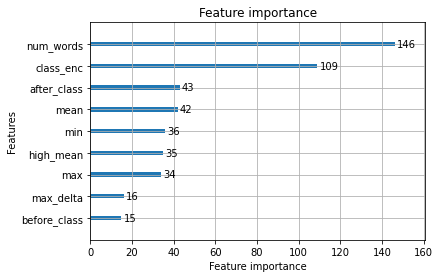

In [45]:
lgb.plot_importance(clf)

In [46]:
y_preds = clf.predict_proba(X)

In [47]:
fold_preds = candidates_df.copy()
fold_preds['preds'] = (y_preds[:, 1] >= 0.5)

In [48]:
score_feedback_comp(fold_preds[fold_preds['preds'] == True], train_df, True)

(0.7083683590727805,
 {'Lead': 0.841349223238987,
  'Position': 0.7290548906314486,
  'Evidence': 0.7697538389272254,
  'Claim': 0.671740011851667,
  'Concluding Statement': 0.8729677395783859,
  'Counterclaim': 0.5766102645601571,
  'Rebuttal': 0.4971025447215923})

In [ ]:
# (0.7105449396404865,
#  {'Lead': 0.8420441347270615,
#   'Position': 0.728785586576812,
#   'Evidence': 0.7723264803092263,
#   'Claim': 0.6706895114223779,
#   'Concluding Statement': 0.871722027972028,
#   'Counterclaim': 0.5849661560384752,
#   'Rebuttal': 0.503280680437424})


In [ ]:
# with open('../decoder_2000/decoder_model.pickle', 'wb') as handle:
#     pickle.dump(clf, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# the best (lightgbm)
# clf = lightgbm.LGBMClassifier(n_estimators=5, num_leaves=50, max_depth=6, min_child_samples=30, reg_lambda=0.005).fit(X_train, y_train)
# 0.7099322865966092